# Fig: Z traversal

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.linear import mi_analysis

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
fits = [
    'fixate1_nf-420_beta-0.15_(2023_04_27,20:20)',
    'vanilla_fixate1_nf-420_beta-1.5_(2023_05_14,14:16)',
]

## Load

In [3]:
fit = fits[0]
model = extract_info(fit)[-1]
tr, meta = load_model_lite(pjoin(results_dir(), fit, 'Trainer'), device='cuda')

### Sample

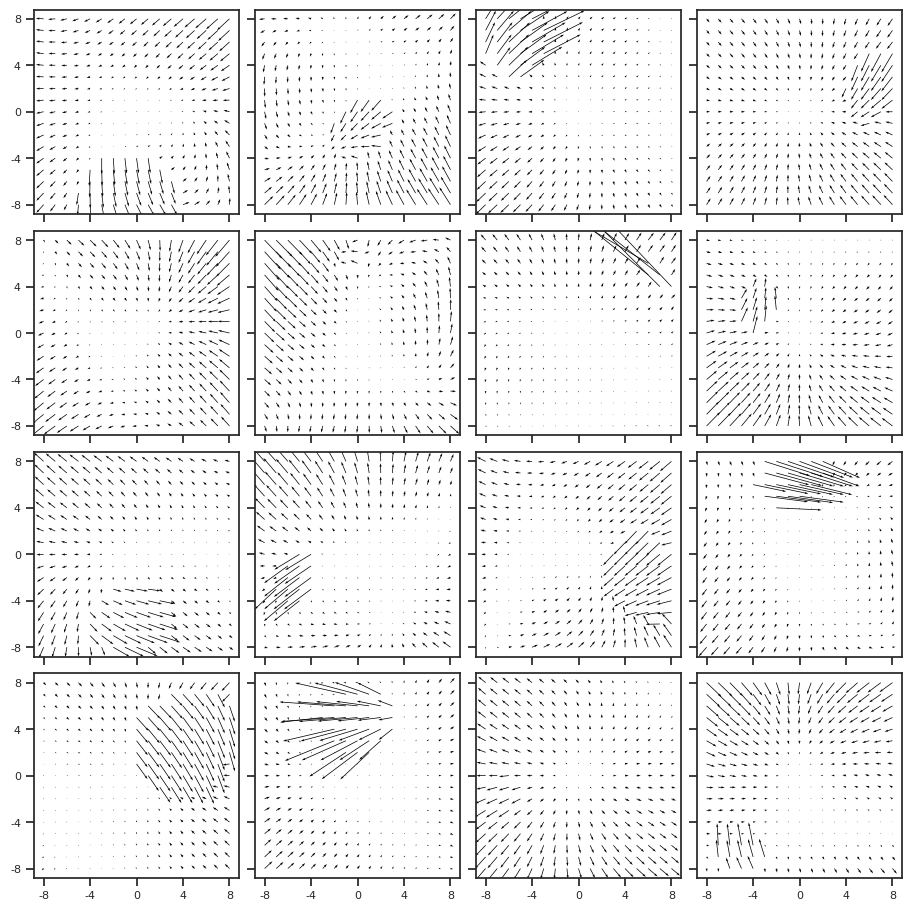

In [4]:
x, *_ = tr.sample()
fig, axes = show_opticflow(x)

In [5]:
fig.savefig(pjoin(fig_base_dir, f'samples_{model}.pdf'), **kws_fig)

## Load mi, identify latent

In [6]:
g, g_tst, select_i, select_lbl = prep_rofl(
    labels=list(LBL2TEX) + ['slf_v_norm', 'slf_v_theta', 'slf_v_phi'])
g.shape

(75000, 14)

In [7]:
%%time

z = tr.forward('vld', True)[0]['z']
z_tst = tr.forward('tst', True)[0]['z']

CPU times: user 30.5 s, sys: 1.5 s, total: 32 s
Wall time: 32 s


In [8]:
r = 1 - sp_dist.cdist(
    np.concatenate([z, z_tst]).T,
    np.concatenate([g, g_tst]).T,
    metric='correlation',
)
r.shape

(420, 14)

In [9]:
np.min(r), np.max(r)

(-0.9145032939544993, 0.8690360758857548)

In [10]:
row_ind, col_ind = sp_optim.linear_sum_assignment(
    cost_matrix=np.abs(r), maximize=True)
row_ind.shape, col_ind.shape

((14,), (14,))

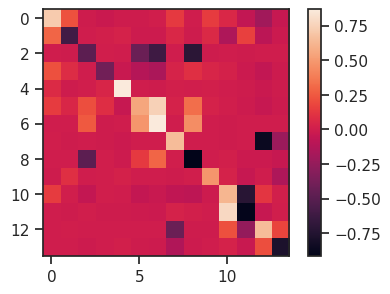

In [11]:
plt.imshow(r[row_ind][:, col_ind])
plt.colorbar();

In [12]:
np.diag(r[row_ind][:, col_ind])

array([ 0.72147141, -0.60298208, -0.48889893, -0.39352068,  0.86352409,
        0.55356459,  0.86903608,  0.65119079, -0.91450329,  0.48389071,
        0.61853869, -0.90022343,  0.65290084, -0.77690545])

In [13]:
best_latents = {select_lbl[i]: j for i, j in zip(col_ind, row_ind)}
best_latents = {lbl: best_latents.get(lbl) for lbl in select_lbl}
print(best_latents)

{
    'fix_x': 296,
    'fix_y': 248,
    'slf_v_norm': 154,
    'slf_v_theta': 353,
    'slf_v_phi': 284,
    'slf_v_x': 393,
    'slf_v_y': 375,
    'slf_v_z': 368,
    'obj0_x': 92,
    'obj0_y': 206,
    'obj0_z': 105,
    'obj0_v_x': 338,
    'obj0_v_y': 60,
    'obj0_v_z': 63
}

In [14]:
j = 296

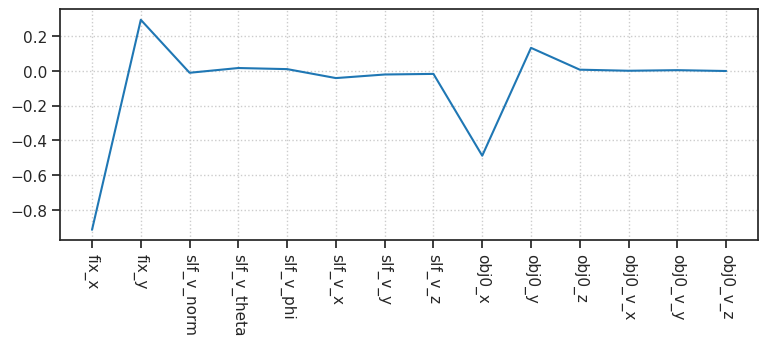

In [15]:
fig, ax = create_figure(1, 1, (9, 3))
ax.plot(r[j])
ax.tick_params(axis='x', rotation=-90)
ax.set(
    xticks=range(len(select_lbl)),
    xticklabels=select_lbl,
)
ax.grid()
plt.show()

In [16]:
%%time

mi = mi_analysis(
    z=np.concatenate([z, z_tst]),
    g=np.concatenate([g, g_tst]),
)

CPU times: user 25.4 s, sys: 11.5 s, total: 36.9 s
Wall time: 10min 21s


In [17]:
list(mi)

['mi', 'mi_norm', 'mig']

In [18]:
mi['mi_norm'].shape

(14, 420)

In [19]:
np.argsort(mi['mi'][2])[::-1][:5], np.argsort(mi['mi_norm'][2])[::-1][:5]

(array([154, 122, 254, 243, 363]), array([154, 122, 254, 363, 243]))

In [20]:
best_i = np.argmax(mi['mi'][2])
best_i

154

In [21]:
mi['mi'][2, best_i]

1.3945816839887355

In [25]:
np.argsort(mi['mi'][2])[-2:]

array([122, 154])

In [22]:
l2t = {
    'fix_x': r'$F_x$',
    'fix_y': r'$F_y$',
    'slf_v_norm': r'$\rho$',
    'slf_v_theta': r'$\theta$',
    'slf_v_phi': r'$\phi$',
    'slf_v_x': r'$V_{self, x}$',
    'slf_v_y': r'$V_{self, y}$',
    'slf_v_z': r'$V_{self, z}$',
    'obj0_x': r'$X_{obj}$',
    'obj0_y': r'$Y_{obj}$',
    'obj0_z': r'$Z_{obj}$',
    'obj0_v_x': r'$V_{obj, x}$',
    'obj0_v_y': r'$V_{obj, y}$',
    'obj0_v_z': r'$V_{obj, z}$',
}

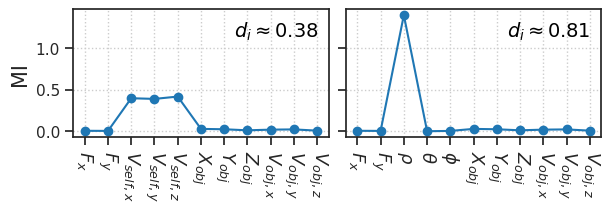

In [26]:
fig, axes = create_figure(1, 2, (6, 2), sharey='row', layout='constrained')
for i in range(2):
    if i == 0:
        exclude = ['slf_v_norm', 'slf_v_theta', 'slf_v_phi']
    else:
        exclude = ['slf_v_x', 'slf_v_y', 'slf_v_z']
    inds = [
        i for i, lbl in
        enumerate(select_lbl)
        if lbl not in exclude
    ]
    
    x2p = mi['mi'][:, best_i][inds]
    d = 1 - entropy_normalized(x2p / sum(x2p))
    axes[i].plot(x2p, marker='o')
    axes[i].tick_params(axis='x', rotation=-90, labelsize=13)
    axes[i].set(
        xticks=range(len(inds)),
        xticklabels=[l2t[select_lbl[i]] for i in inds],
    )
    axes[i].annotate(
        text=r"$d_i \approx $" + f"{d:0.2f}",
        xy=(0.63, 0.78),
        xycoords='axes fraction',
        color='k',
        fontsize=14,
    )
    axes[i].grid()
axes[0].set_ylabel('MI', fontsize=15)
plt.show()

In [27]:
fig.savefig(pjoin(fig_base_dir, 'polar2cart_mi.pdf'), **kws_fig)

In [83]:
z_both = np.concatenate([z, z_tst])
g_both = np.concatenate([g, g_tst])

z_both.shape, g_both.shape

((150000, 420), (150000, 14))

In [84]:
label_lists = {
    'carte': ['slf_v_x', 'slf_v_y', 'slf_v_z'],
    'polar': ['slf_v_norm', 'slf_v_theta', 'slf_v_phi'],
}
_y = z_both[:, best_i]
_y = sp_stats.zscore(_y)

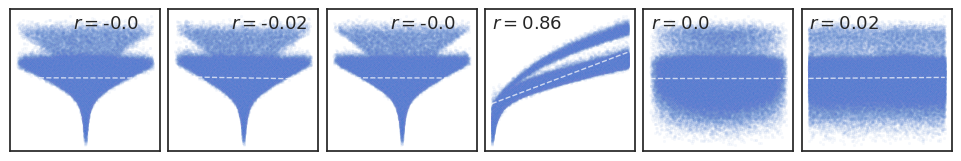

In [88]:
fig, axes = create_figure(1, 6, (9.5, 1.5), sharey='all', layout='constrained')

ii = 0
for k, v in label_lists.items():
    for lbl in v:
        i = select_lbl.index(lbl)
        _x = g_both[:, i]
        # lin regress
        lr = sp_stats.linregress(_x, _y)
        x_min = _x.min()
        x_max = _x.max()
        xs = np.linspace(x_min, x_max, 1000)
        ys = lr.slope * xs + lr.intercept
        sns.scatterplot(
            x=_x,
            y=_y,
            s=5,
            alpha=0.05,
            # bins=20,
            color=get_palette()[0]['cNVAE'],
            ax=axes[ii],
        )
        axes[ii].plot(xs, ys, color='white', ls='--', lw=1.0, alpha=0.7)
        axes[ii].annotate(
            text=r'$r = $' + str(np.round(lr.rvalue, 2)),
            xy=(0.05 if lr.rvalue > 0 else 0.42, 0.865),
            xycoords='axes fraction',
            fontsize=13,
        )
        ii += 1
remove_ticks(axes, False)
plt.show()

In [93]:
for k, v in label_lists.items():
    for lbl in v:
        i = select_lbl.index(lbl)
        r, _ = sp_stats.pearsonr(g_both[:, i], z_both[:, best_i])
        print(f"{lbl}:\tr = {r:0.2f}")

slf_v_x:        r = -0.00

slf_v_y:        r = -0.02

slf_v_z:        r = -0.00

slf_v_norm:     r = 0.86

slf_v_theta:    r = 0.00

slf_v_phi:      r = 0.02

## Traversal

In [4]:
x, _ = next(iter(tr.dl_trn))

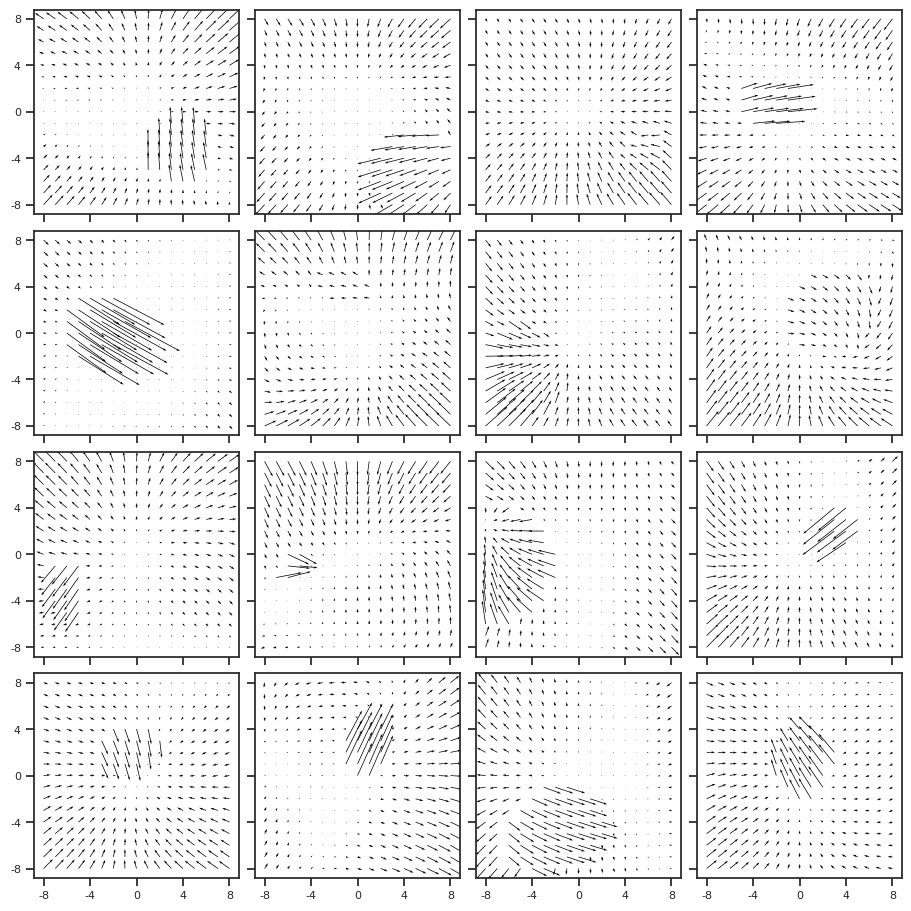

In [5]:
fig, _ = show_opticflow(x)

In [7]:
fig.savefig(pjoin(fig_base_dir, 'samples_fixate1.pdf'), **kws_fig)

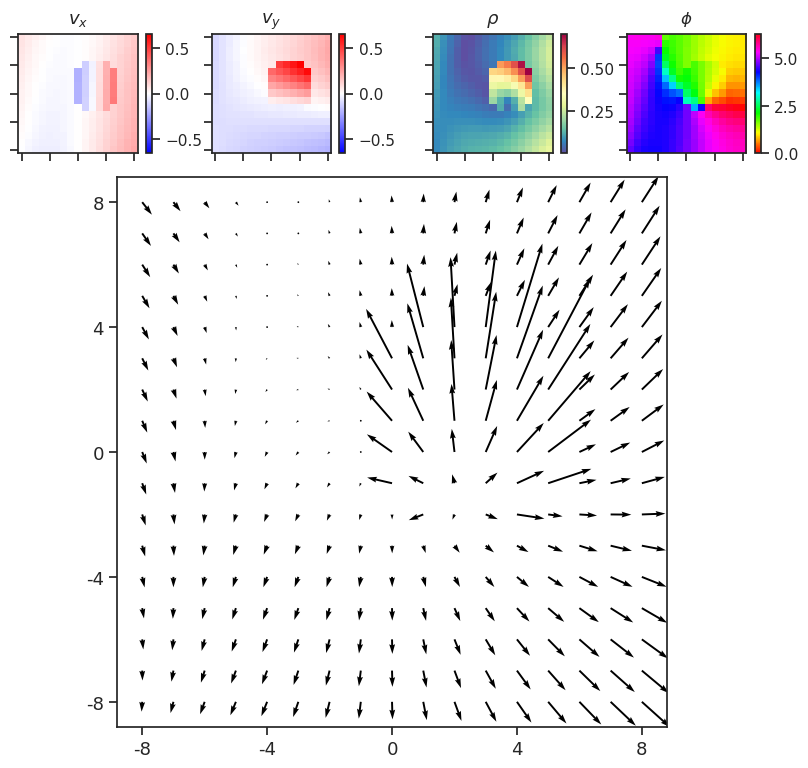

In [203]:
which_sample = 11
show_opticflow_full(x[which_sample]);

In [356]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

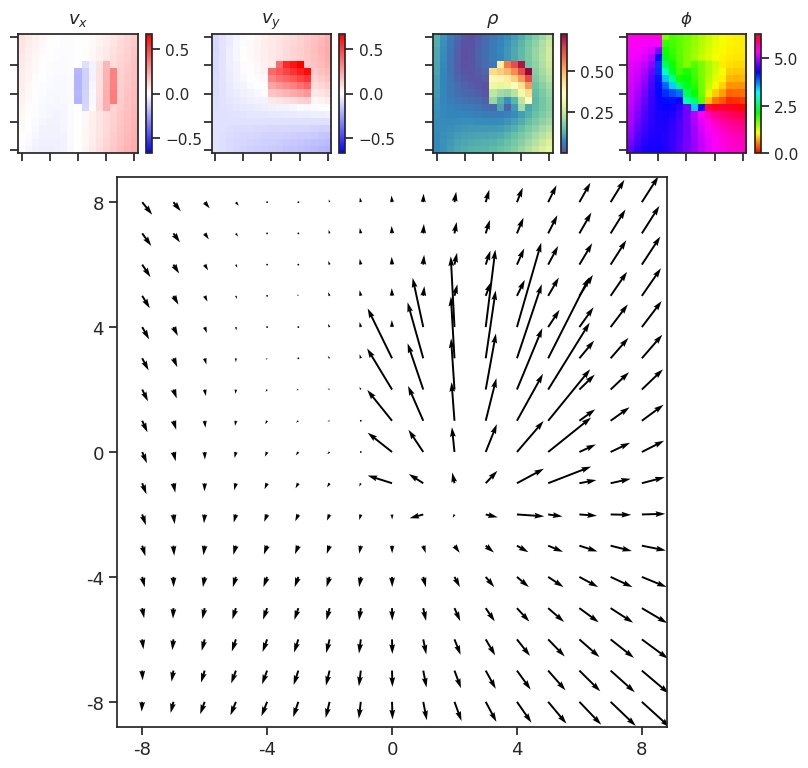

In [357]:
show_opticflow_full(x_hat[which_sample]);

In [358]:
# z = torch.cat(z, dim=1).squeeze()

## Obj_y

In [584]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

In [585]:
select_lbl[9]

'obj0_y'

In [586]:
best_i = np.argsort(mi['mi'][9])[-1]
best_i

2

In [587]:
which_group, which_latent = best_i // 21, best_i % 21
which_group, which_latent

(0, 2)

In [588]:
mu = q[which_group].mu[which_sample, which_latent].squeeze()
sig = q[which_group].sigma[which_sample, which_latent].squeeze()
mu, sig

(tensor(0.1701, device='cuda:0'), tensor(0.4481, device='cuda:0'))

In [589]:
z[which_group][which_sample, which_latent].squeeze()

tensor(0.3913, device='cuda:0')

In [590]:
num = 8
z_trav = z.copy()
z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
z_trav[which_group][:, which_latent] = torch.linspace(
    mu - 5 * sig, mu + 5 * sig, num).unsqueeze(-1).unsqueeze(-1)

In [591]:
z_trav[which_group][:, which_latent].squeeze()

tensor([-2.0704, -1.4303, -0.7901, -0.1500,  0.4901,  1.1303,  1.7704,  2.4106],
       device='cuda:0')

In [592]:
self = tr.model

In [593]:
from vae.vae2d import CombinerDec, Normal

In [594]:
with torch.no_grad():
    idx = 0
    s = self.prior_ftr0.unsqueeze(0)
    s = s.expand(z_trav[idx].size(0), -1, -1, -1)
    for cell in self.dec_tower:
        if isinstance(cell, CombinerDec):
            s = cell(s, self.expand[idx](z_trav[idx]))
            idx += 1
        else:
            s = cell(s)

    for cell in self.post_process:
        s = cell(s)
    x_gen = self.out(s)

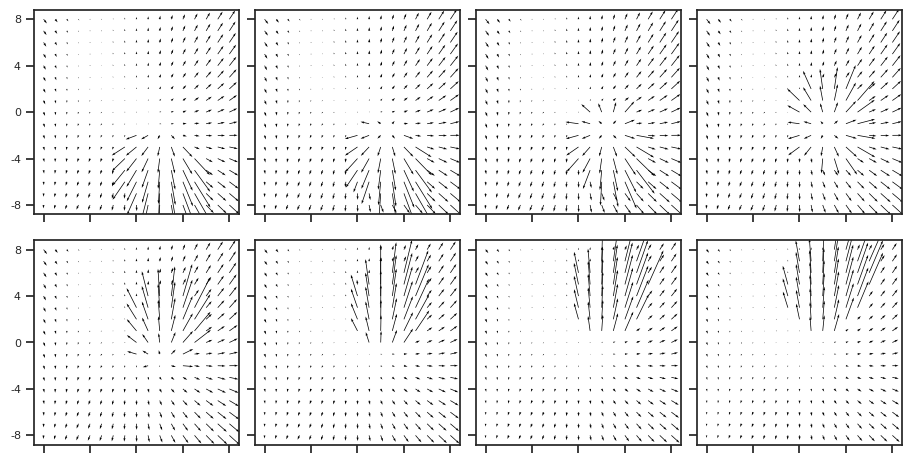

In [595]:
show_opticflow(x_gen);

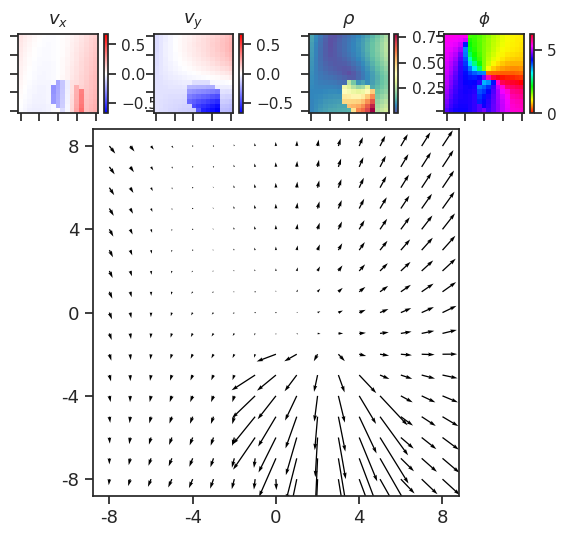

In [596]:
show_opticflow_full(x_gen[0], figsize=(7, 6));

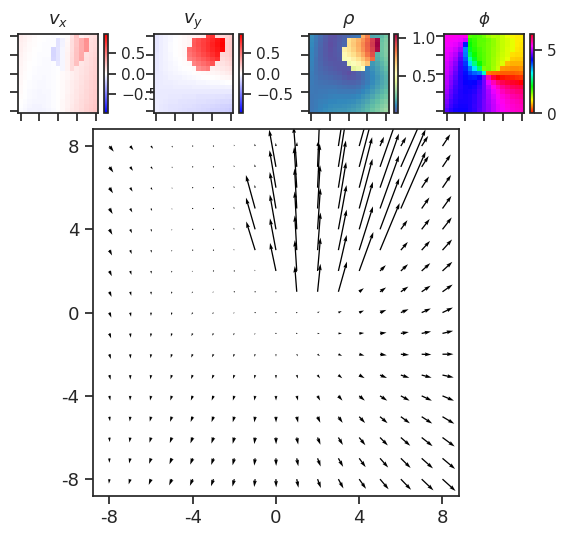

In [597]:
show_opticflow_full(x_gen[-1], figsize=(7, 6));

## Obj_x

In [666]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

In [667]:
select_lbl[8]

'obj0_x'

In [668]:
best_i = np.argsort(mi['mi'][8])[-1]
best_i

5

In [669]:
which_group, which_latent = best_i // 21, best_i % 21
which_group, which_latent

(0, 5)

In [670]:
mu = q[which_group].mu[which_sample, which_latent].squeeze()
sig = q[which_group].sigma[which_sample, which_latent].squeeze()
mu, sig

(tensor(-1.1883, device='cuda:0'), tensor(0.2592, device='cuda:0'))

In [671]:
z[which_group][which_sample, which_latent].squeeze()

tensor(-1.1757, device='cuda:0')

In [672]:
num = 8
z_trav = z.copy()
z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
z_trav[which_group][:, which_latent] = torch.linspace(
    mu - 5 * sig, mu + 5 * sig, num).unsqueeze(-1).unsqueeze(-1)

In [673]:
z_trav[which_group][:, which_latent].squeeze()

tensor([-2.4843, -2.1140, -1.7437, -1.3734, -1.0032, -0.6329, -0.2626,  0.1077],
       device='cuda:0')

In [674]:
self = tr.model

In [675]:
from vae.vae2d import CombinerDec, Normal

In [676]:
with torch.no_grad():
    idx = 0
    s = self.prior_ftr0.unsqueeze(0)
    s = s.expand(z_trav[idx].size(0), -1, -1, -1)
    for cell in self.dec_tower:
        if isinstance(cell, CombinerDec):
            s = cell(s, self.expand[idx](z_trav[idx]))
            idx += 1
        else:
            s = cell(s)

    for cell in self.post_process:
        s = cell(s)
    x_gen = self.out(s)

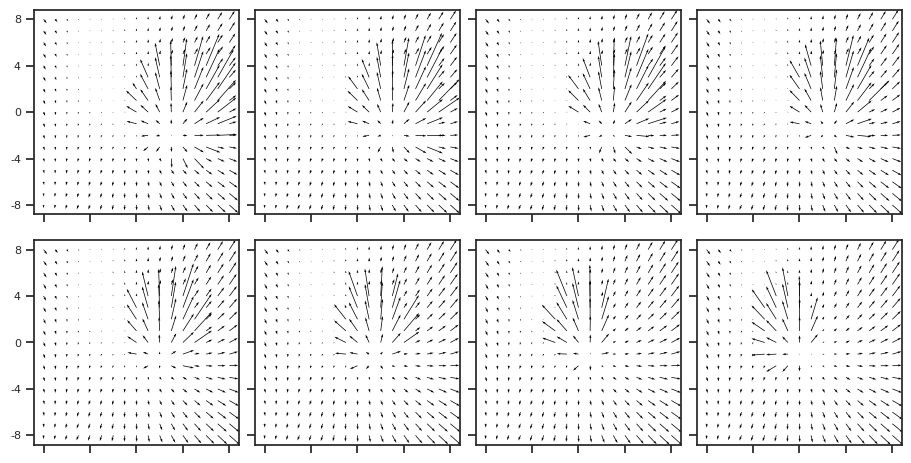

In [677]:
show_opticflow(x_gen);

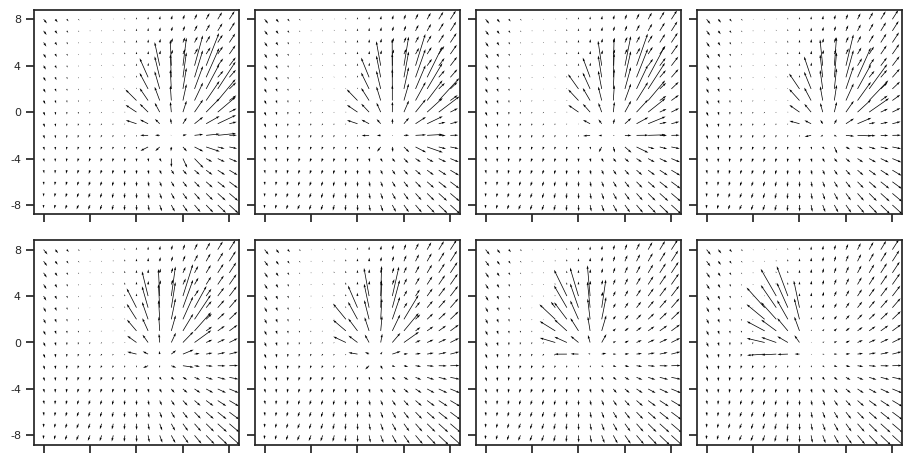

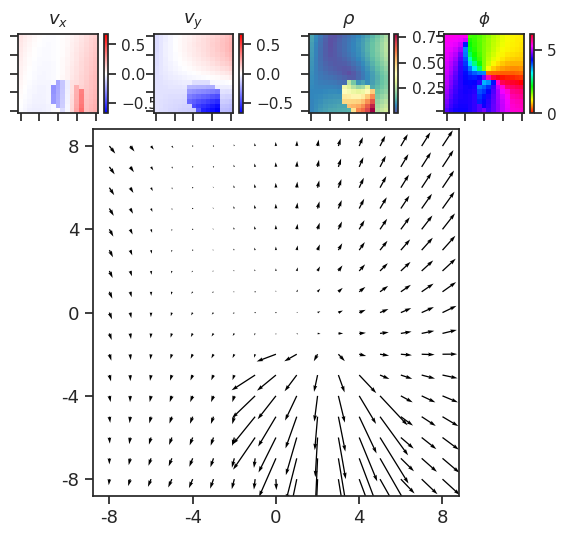

In [596]:
show_opticflow_full(x_gen[0], figsize=(7, 6));

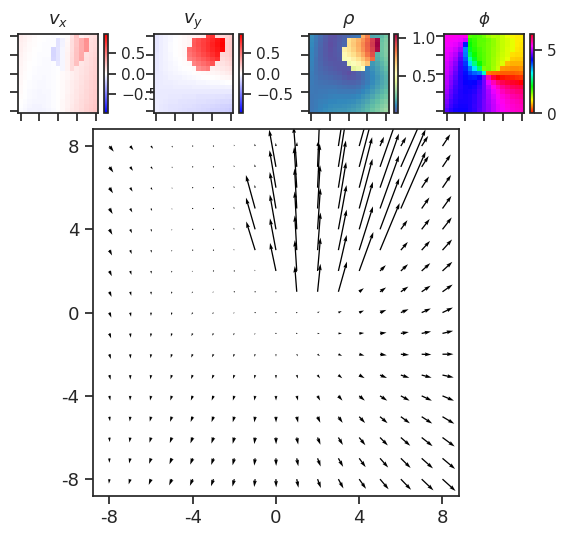

In [597]:
show_opticflow_full(x_gen[-1], figsize=(7, 6));

## Self norm

In [602]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

In [616]:
ii = 2
lbl = select_lbl[ii]
best_i = np.argsort(mi['mi'][ii])[-3]
lbl, best_i

('slf_v_norm', 254)

In [617]:
which_group, which_latent = best_i // 21, best_i % 21
which_group, which_latent

(12, 2)

In [618]:
mu = q[which_group].mu[which_sample, which_latent].squeeze()
sig = q[which_group].sigma[which_sample, which_latent].squeeze()
mu, sig

(tensor(22.9833, device='cuda:0'), tensor(0.4380, device='cuda:0'))

In [619]:
z[which_group][which_sample, which_latent].squeeze()

tensor(22.4985, device='cuda:0')

In [620]:
num = 8
z_trav = z.copy()
z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
z_trav[which_group][:, which_latent] = torch.linspace(
    mu - 5 * sig, mu + 5 * sig, num).unsqueeze(-1).unsqueeze(-1)

In [621]:
z_trav[which_group][:, which_latent].squeeze()

tensor([20.7931, 21.4188, 22.0446, 22.6704, 23.2961, 23.9219, 24.5477, 25.1735],
       device='cuda:0')

In [622]:
with torch.no_grad():
    idx = 0
    s = self.prior_ftr0.unsqueeze(0)
    s = s.expand(z_trav[idx].size(0), -1, -1, -1)
    for cell in self.dec_tower:
        if isinstance(cell, CombinerDec):
            s = cell(s, self.expand[idx](z_trav[idx]))
            idx += 1
        else:
            s = cell(s)

    for cell in self.post_process:
        s = cell(s)
    x_gen = self.out(s)

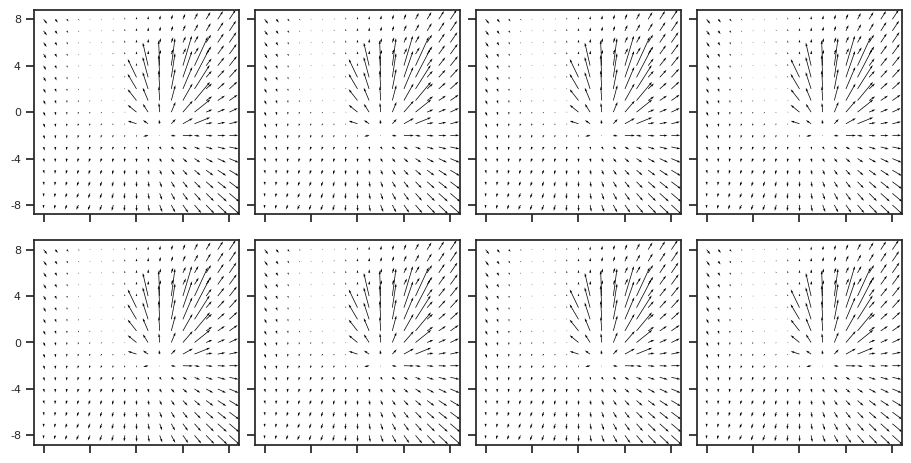

In [623]:
show_opticflow(x_gen);

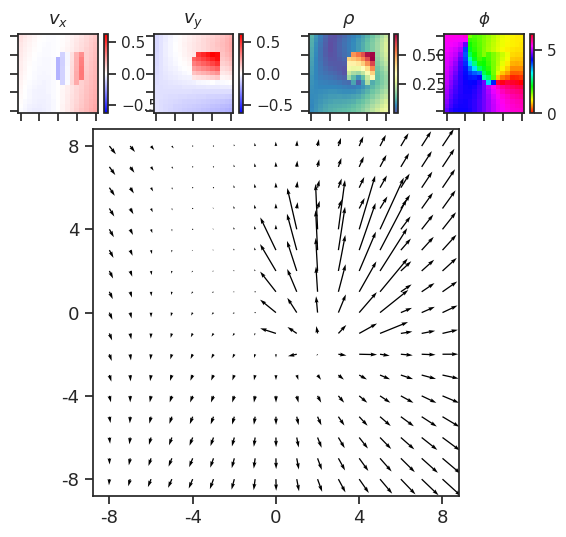

In [624]:
show_opticflow_full(x_gen[0], figsize=(7, 6));

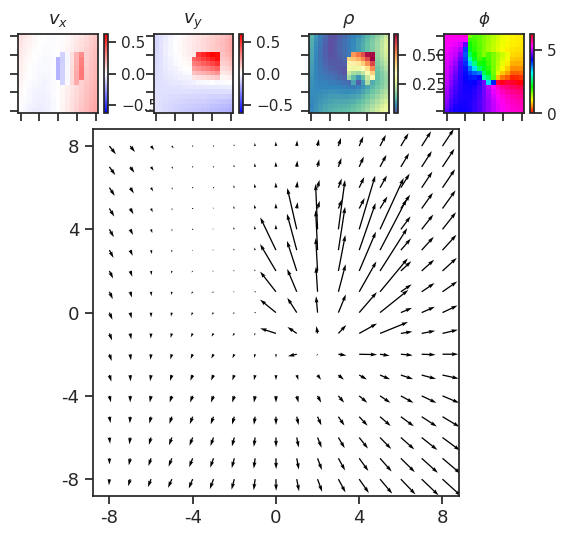

In [625]:
show_opticflow_full(x_gen[-1], figsize=(7, 6));

## Final, generate

In [678]:
with torch.no_grad():
    x_hat, z, q, p = tr.model(x)

In [679]:
select_lbl[9]

'obj0_y'

In [680]:
best_i = np.argsort(mi['mi'][9])[-1]
best_i

2

In [681]:
which_group, which_latent = best_i // 21, best_i % 21
which_group, which_latent

(0, 2)

In [707]:
which_sample = 11

In [708]:
mu = q[which_group].mu[which_sample, which_latent].squeeze()
sig = q[which_group].sigma[which_sample, which_latent].squeeze()
mu, sig

(tensor(0.1701, device='cuda:0'), tensor(0.4481, device='cuda:0'))

In [709]:
z[which_group][which_sample, which_latent].squeeze()

tensor(-0.7501, device='cuda:0')

In [716]:
use_this = torch.linspace(mu - 6 * sig, mu + 3 * sig, num).unsqueeze(-1).unsqueeze(-1)

In [717]:
num = 7
z_trav = z.copy()
z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
z_trav[which_group][:, which_latent] = use_this

In [718]:
z_trav[which_group][:, which_latent].squeeze()

tensor([-2.5185, -1.8464, -1.1742, -0.5021,  0.1701,  0.8422,  1.5144],
       device='cuda:0')

In [719]:
with torch.no_grad():
    idx = 0
    s = self.prior_ftr0.unsqueeze(0)
    s = s.expand(z_trav[idx].size(0), -1, -1, -1)
    for cell in self.dec_tower:
        if isinstance(cell, CombinerDec):
            s = cell(s, self.expand[idx](z_trav[idx]))
            idx += 1
        else:
            s = cell(s)

    for cell in self.post_process:
        s = cell(s)
    x_gen = self.out(s)

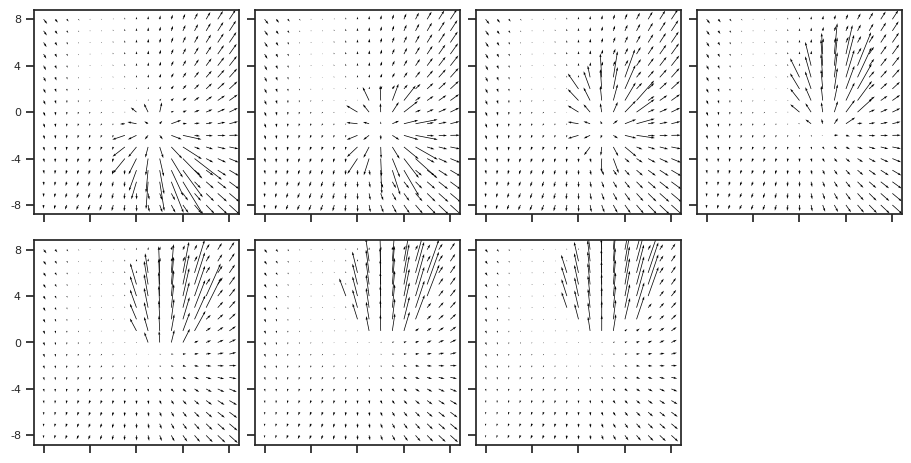

In [720]:
show_opticflow(x_gen);

In [730]:
num = 7
x_gen_all = []
for i in range(num+2):
    which_sample = i + 11
    z_trav = z.copy()
    z_trav = [torch.repeat_interleave(e[[which_sample]], num, dim=0) for e in z_trav]
    z_trav[which_group][:, which_latent] = use_this
    
    with torch.no_grad():
        idx = 0
        s = self.prior_ftr0.unsqueeze(0)
        s = s.expand(z_trav[idx].size(0), -1, -1, -1)
        for cell in self.dec_tower:
            if isinstance(cell, CombinerDec):
                s = cell(s, self.expand[idx](z_trav[idx]))
                idx += 1
            else:
                s = cell(s)

        for cell in self.post_process:
            s = cell(s)
        x_gen = self.out(s)
        x_gen_all.append(x_gen)

In [731]:
x_gen_all = torch.stack(x_gen_all)
x_gen_all.shape

torch.Size([9, 7, 2, 17, 17])

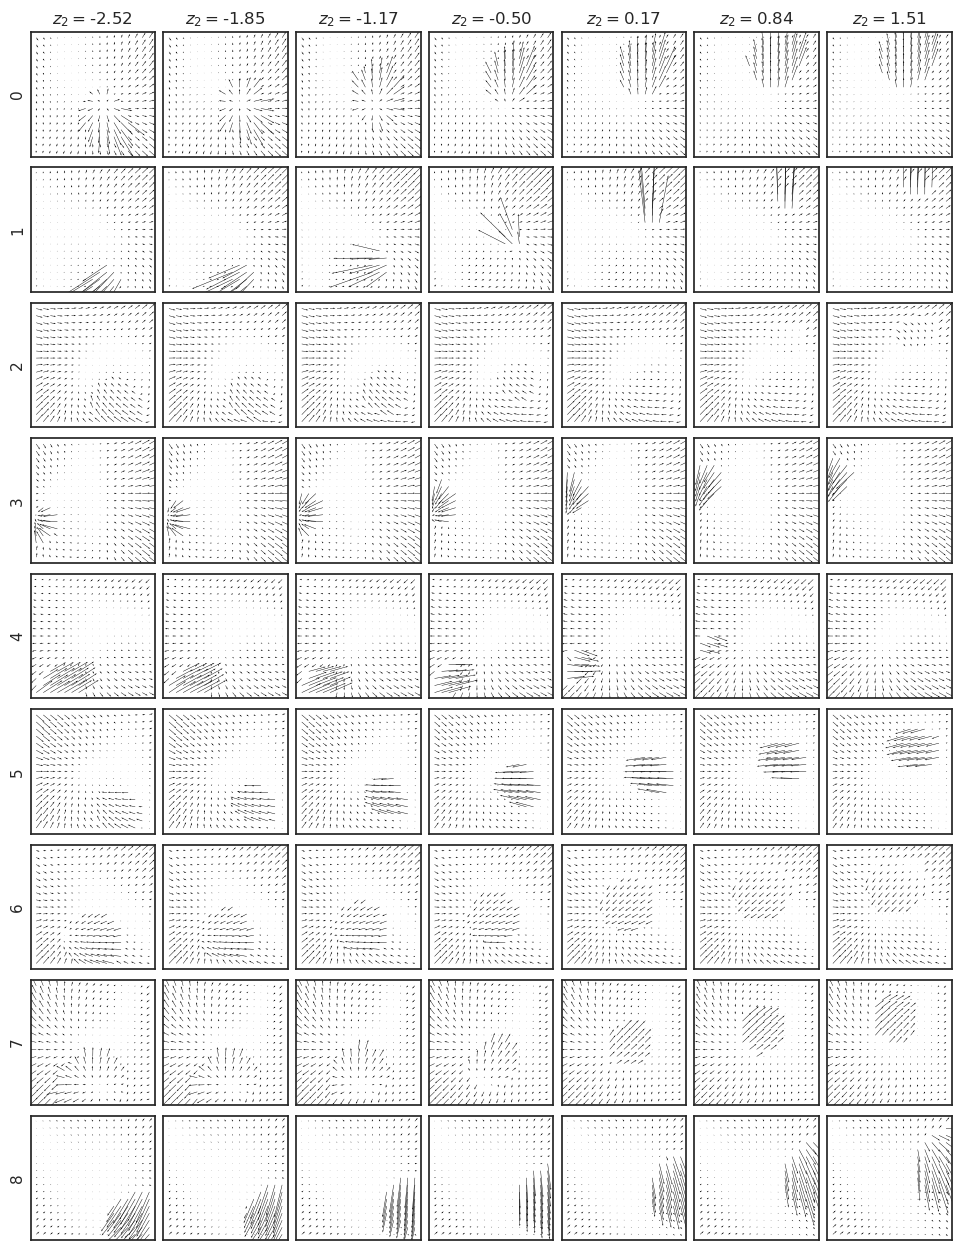

In [754]:
fig, axes = show_opticflow_row(x_gen_all, figsize=(9.5, 12.4), display=False)
for i in range(7):
    axes[0, i].set_title(r"$z_2 = $" + f"{to_np(use_this)[i].item():0.2f}", fontsize=12)
for j in range(9):
    axes[j, 0].set_ylabel(f"{j}", fontsize=11)
display(fig)

In [755]:
fig.savefig(pjoin(fig_base_dir, 'traverse_objy.pdf'), **kws_fig)